In [1]:
from pickle import load
from keras.models import load_model
from preprocess import *
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from nltk.translate.bleu_score import corpus_bleu
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
wordtoix = load(open('wordtoix.pkl', 'rb'))
ixtoword = load(open('ixtoword.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_len = 15

In [3]:
# load the model
filename = 'model.h5'
model = load_model(filename)

In [4]:
def greedySearch(model, photo, max_len, wordtoix, ixtoword):
    in_text = 'startseq'
    for i in range(max_len):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_len)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [5]:
# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, max_len, wordtoix, ixtoword):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc_list in descriptions.items():
        # generate description
        yhat = greedySearch(model, photos[key], max_len, wordtoix, ixtoword)
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
 

In [6]:
# prepare test set
 
# load test set
filename = 'Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('features.pkl', test)
print('Photos: test=%d' % len(test_features))
 

Dataset: 1000
Descriptions: test=1000
Photos: test=1000


In [7]:
# evaluate model
evaluate_model(model, test_descriptions, test_features, max_len, wordtoix, ixtoword)

BLEU-1: 0.401569
BLEU-2: 0.224036
BLEU-3: 0.151062
BLEU-4: 0.067206


In [8]:
keys=[i for i in test_features.keys()]

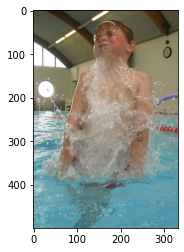

boy in swim trunks is splashing in the water


In [11]:
i=keys[100]
image="Flicker8k_Dataset/"+i+".jpg"
x=plt.imread(image)
plt.imshow(x)
plt.show()
print(greedySearch(model,test_features[i],max_len, wordtoix, ixtoword))